###### Table of contents

### - Import libraries and define functions + Initial setup

### - Figure 2

### - Figure 3

### - Figure 4

### - Figure 5

### - Output novel high-confidence only annotation

# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    ## Group by gene_id and get total expression for each gene (not counting introns)
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]
    df_sums.drop(columns="total_CPM", inplace=True)
    
    ## Merge dataframe with total gene level CPM with regular transcript level CPM dataframe
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    ## Calculater relative percent abundance for each transcript within its gene
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    ## Rename total_CPM for transcript column
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [7]:
## Open original reference
original_ref = pd.read_csv("../../references/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

original_ref = original_ref.loc[~original_ref["chr"].str.startswith("ERCC-")]

## Parse through reference to get gene names and ids
orig_ref = original_ref.loc[original_ref["type"]=="gene"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=True)

## Import disease relevant genes
disease_relevant_genes = pd.read_csv("../../references/medically_relevant_genes_02-04-2023_UPDATED.tsv", sep="\t")

## Brain disease genes
brain_disease_gene_ids = pd.read_csv("../../references/brain_disease_genes_only_IDs.tsv", sep="\t")
brain_disease_annotations = pd.read_csv("../../references/brain_disease_genes_with_disease.tsv", sep="\t")

## Import AD Genes
ad_names = pd.read_csv("../../references/AD_gwas_genes.tsv", sep="\t")

## Create disease relevant list including chromosome
disease_relevant_genes_annotated = disease_relevant_genes.merge(orig_ref[["gene_id", "gene_name", "chr"]], 
                                                               how="inner", on=["gene_id", "gene_name"])

## Create list of protein coding genes
protein_coding_ref = orig_ref.loc[orig_ref["gene_biotype"] == "protein_coding"].copy()

## Import and parse through extended annotations
ref = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

ref = ref.loc[~ref["chr"].str.startswith("ERCC-")]

ref = parse_df_columns(ref, is_ref=False)

ref_transcripts = ref.loc[ref["type"] == "transcript"].copy()

# - Figure 2

In [8]:
## Import data for transcript level counts and fix column names

df = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df = fix_column_names(df, is_gene=False)

In [9]:
## Calculate total counts
df["total_counts"] = df[df.filter(regex='count').columns].sum(axis=1)

In [10]:
## Calculate CPM and drop count columns
df = calculate_cpm(df, is_gene=False)

df = df[df.columns.drop(list(df.filter(regex='counts')))].copy()

In [11]:
## Drop ERCCs
df = df.loc[~df["gene_id"].str.startswith("ERCC")].copy()

In [12]:
## Calculate median CPM
df["median_CPM"] = df[df.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [13]:
## Annotate transcritps in counts matrix
df = df.merge(ref_transcripts[["gene_id", "transcript_id", "chr"]], on=["gene_id", "transcript_id"], how="inner")

In [14]:
## Create dataframes with either only novel genes or only novel transcripts that are not from novel genes
df_novel_genes = df.loc[df["gene_id"].str.startswith("BambuGene")].copy()
df_novel_transcripts = df.loc[((df["transcript_id"].str.startswith("BambuTx")) & (~df["gene_id"].str.startswith("BambuGene")))].copy()

In [15]:
## Drop new mitochondrial transcripts/genes
df_novel_genes = df_novel_genes.loc[df_novel_genes["chr"] != "MT"].copy()
df_novel_transcripts = df_novel_transcripts.loc[df_novel_transcripts["chr"] != "MT"].copy()

In [16]:
## Filter novel genes and transcripts, median CPM > 1
df_novel_genes_median = df_novel_genes[df_novel_genes["median_CPM"] > 1].copy()
df_novel_transcripts_median = df_novel_transcripts[df_novel_transcripts["median_CPM"] > 1].copy()

In [17]:
## Only keep exon entries and add size variable
ref_exons = ref.loc[ref["type"] == "exon"].copy()
ref_exons["size"] = abs(ref_exons["end"] - ref_exons["start"])

In [18]:
## Get reference for novel genes and transcripts
ref_novel_gene_median = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_genes_median["transcript_id"])].copy()
ref_novel_transcript_median = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_transcripts_median["transcript_id"])].copy()


ref_novel_gene = ref_exons.loc[ref_exons["gene_id"].str.startswith("BambuGene")].copy()
ref_novel_transcript = ref_exons.loc[((ref_exons["transcript_id"].str.startswith("BambuTx")) & 
                                      (~ref_exons["gene_id"].str.startswith("BambuGene")))].copy()

In [19]:
## get number of exons
ref_novel_gene_median_num_exons = ref_novel_gene_median["transcript_id"].value_counts()
ref_novel_transcript_median_num_exons = ref_novel_transcript_median["transcript_id"].value_counts()

ref_novel_gene_num_exons = ref_novel_gene["transcript_id"].value_counts()
ref_novel_transcript_num_exons = ref_novel_transcript["transcript_id"].value_counts()

In [71]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (330*mm, 165*mm)
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 3

In [21]:
## Create dataframes with exonic length for each transcript
df_exonic_length_novel_genes_median = ref_novel_gene_median[["transcript_id", "size"]].groupby('transcript_id').sum()
df_exonic_length_novel_transcripts_median = ref_novel_transcript_median[["transcript_id", "size"]].groupby('transcript_id').sum()

df_exonic_length_novel_genes = ref_novel_gene[["transcript_id", "size"]].groupby('transcript_id').sum()
df_exonic_length_novel_transcripts = ref_novel_transcript[["transcript_id", "size"]].groupby('transcript_id').sum()

In [22]:
df_exonic_length_novel_transcripts_median["size"].describe()

count     428.000000
mean      870.521028
std       484.218927
min       179.000000
25%       504.750000
50%       761.500000
75%      1137.000000
max      3089.000000
Name: size, dtype: float64

In [23]:
## Create log transformation of median CPM for new genes and transcripts

df_novel_genes_no_zero = df_novel_genes.loc[df_novel_genes["median_CPM"] > 0].copy()
log_10_median_cpm_genes = np.log10(df_novel_genes_no_zero["median_CPM"])

df_novel_transcripts_no_zero = df_novel_transcripts.loc[df_novel_transcripts["median_CPM"] > 0].copy()
log_10_median_cpm_transcripts = np.log10(df_novel_transcripts_no_zero["median_CPM"])

In [24]:
## Get number of transcripts

print("Number of transcripts mapping to new gene bodies (no filter):", df_novel_genes.shape[0])
print("Number of transcripts mapping to new gene bodies (median CPM > 1):", df_novel_genes_median.shape[0])

print("\n\nNumber of new transcripts mapping to annotated genes (no filter):", df_novel_transcripts.shape[0])
print("Number of new transcripts mapping to annotated genes (median CPM > 1):", df_novel_transcripts_median.shape[0])

Number of transcripts mapping to new gene bodies (no filter): 1860
Number of transcripts mapping to new gene bodies (median CPM > 1): 267


Number of new transcripts mapping to annotated genes (no filter): 1534
Number of new transcripts mapping to annotated genes (median CPM > 1): 428


In [25]:
## Get number of genes

print("Number of new genes represented (no filter):", df_novel_genes["gene_id"].nunique())
print("Number of new genes represented (median CPM > 1):", df_novel_genes_median["gene_id"].nunique())


print("\n\nNumber of represented annotated genes with new transcripts (no filter):", df_novel_transcripts["gene_id"].nunique())
print("Number of represented annotated genes with new transcripts (median CPM > 1):", df_novel_transcripts_median["gene_id"].nunique())

Number of new genes represented (no filter): 1676
Number of new genes represented (median CPM > 1): 245


Number of represented annotated genes with new transcripts (no filter): 1255
Number of represented annotated genes with new transcripts (median CPM > 1): 383


In [26]:
## Create lists with number of genes across CPM thresholds
list_cpm_thresh = []

list_ntkg_median = []
list_ntkg_median_prot_coding = []
list_ntkg_median_med_relevant = []
list_ntng_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    ntng_median_cpm = df_novel_genes.loc[df_novel_genes["median_CPM"] >= cpm_thresh].copy()
    ntng_median_cpm_num = ntng_median_cpm.shape[0]
        
    
    ntkg_median_cpm = df_novel_transcripts.loc[df_novel_transcripts["median_CPM"] >= cpm_thresh].copy()
    ntkg_median_cpm_num = ntkg_median_cpm.shape[0]
    ntkg_median_cpm_num_prot = ntkg_median_cpm.loc[ntkg_median_cpm["gene_id"].isin(protein_coding_ref["gene_id"])].shape[0]    
    ntkg_median_cpm_num_med = ntkg_median_cpm.loc[ntkg_median_cpm["gene_id"].isin(disease_relevant_genes_annotated["gene_id"])].shape[0] 
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_ntng_median.append(ntng_median_cpm_num)
    
    list_ntkg_median.append(ntkg_median_cpm_num)
    list_ntkg_median_prot_coding.append(ntkg_median_cpm_num_prot)
    list_ntkg_median_med_relevant.append(ntkg_median_cpm_num_med)

In [68]:
list_ntng_median[101]

267

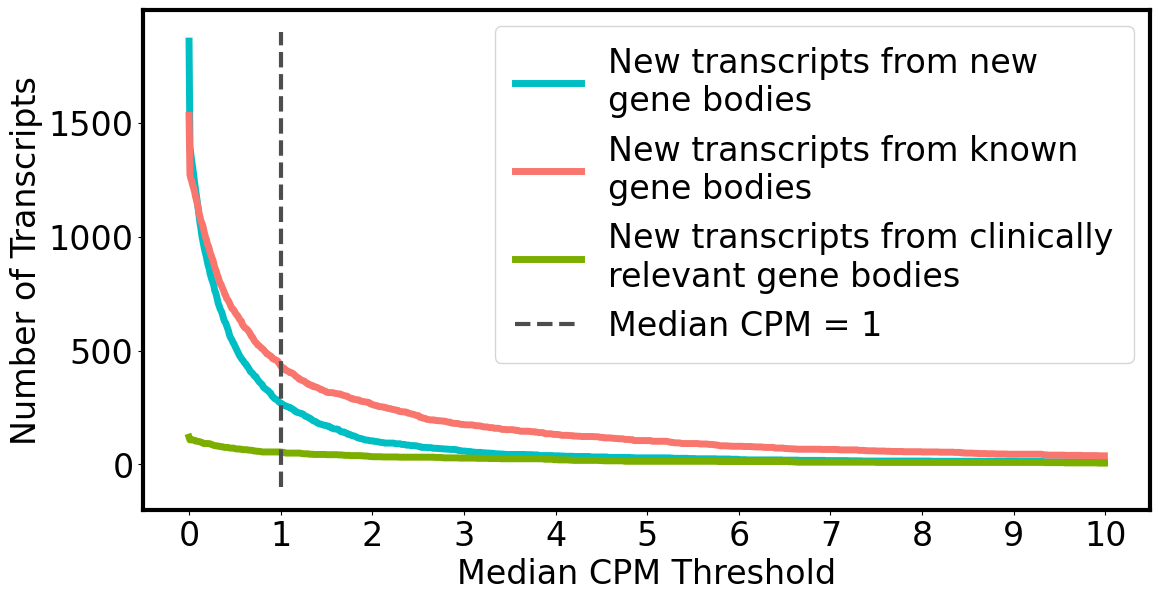

In [72]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_ntng_median, color=ggplot2_colors[4], label="New transcripts from new\ngene bodies", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh, list_ntkg_median, color=ggplot2_colors[0], label="New transcripts from known\ngene bodies", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh, list_ntkg_median_med_relevant, color=ggplot2_colors[2], label="New transcripts from clinically\nrelevant gene bodies", linewidth=5, alpha=1)
plt.plot([1, 1], [-100, 1899], color="#4d4d4d", label="Median CPM = 1", linewidth=3, alpha=1, linestyle='dashed')


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=24, borderpad=0.6, labelspacing=0.5)

plt.savefig('../../figures/ASHG_2023/number_of_new_transcripts_across_cpm_thresh.pdf', dpi=600, transparent=True, bbox_inches="tight")

plt.show()

# Figure 3

In [28]:
## Create list o disease relevant novel transcripts with median  CPM > 1
novel_relevant_median = df_novel_transcripts_median.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

In [29]:
## Drop any duplicates
novel_relevant_median.drop_duplicates(inplace=True)

In [30]:
## Get all transcript from the same gene as the new transcripts so we can calculate relative abundance of 
## New transcripts in each gene
novel_relevant_median_counts = pd.merge(df, novel_relevant_median[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [31]:
novel_relevant_median_counts.drop_duplicates(inplace=True)

In [32]:
## Calculate relative transcript abundance
novel_relevant_median_relative_abundance = relative_transcript_abundance(novel_relevant_median_counts)

In [33]:
## Annotate novel transcripts on relative abundance table
novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_median_relative_abundance.loc[~novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

In [34]:
## Create list with med relevant genes with novel isoforms and their relative frequency
novel_relevant_median_words = novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

In [35]:
## Drop duplicates
novel_relevant_median_words = novel_relevant_median_words.drop_duplicates()

In [36]:
## Sum relative abundance of all novel isoforms by gene name and round to nearest integer
novel_relevant_median_words = round(novel_relevant_median_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [37]:
## Create a dataframe to properly store the data
novel_relevant_median_words_df = pd.DataFrame()
novel_relevant_median_words_df['word_count'] = novel_relevant_median_words
novel_relevant_median_words_df["gene_name"] = novel_relevant_median_words.index

In [38]:
## Drop index
novel_relevant_median_words_df.reset_index(inplace=True, drop=True)

In [39]:
## Print number of disease relevant genes with high-confidence novel isoforms
print("Number of medically relevant genes with novel transcripts (median CPM > 1):", novel_relevant_median_words_df["gene_name"].nunique())

Number of medically relevant genes with novel transcripts (median CPM > 1): 49


In [40]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant median CPM > 1

word_list_disease_median = ""

for i in range(len(novel_relevant_median_words_df)):
        
    for j in range(int(novel_relevant_median_words_df.iloc[i][0])):
        word_list_disease_median = word_list_disease_median + novel_relevant_median_words_df.iloc[i][1] + " "

In [41]:
## Create GGPLOT2 colormap for the wordcloud (THANKS MARK!)

from matplotlib.colors import LinearSegmentedColormap

ggplot2_colormap = LinearSegmentedColormap.from_list(
        "ggplot_2", ggplot2_colors, N=8)

In [42]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (330*mm, 150*mm)
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 3

In [43]:
## Generate wordclouds
word_cloud_disease_median = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=3300, height=1500).generate(word_list_disease_median)

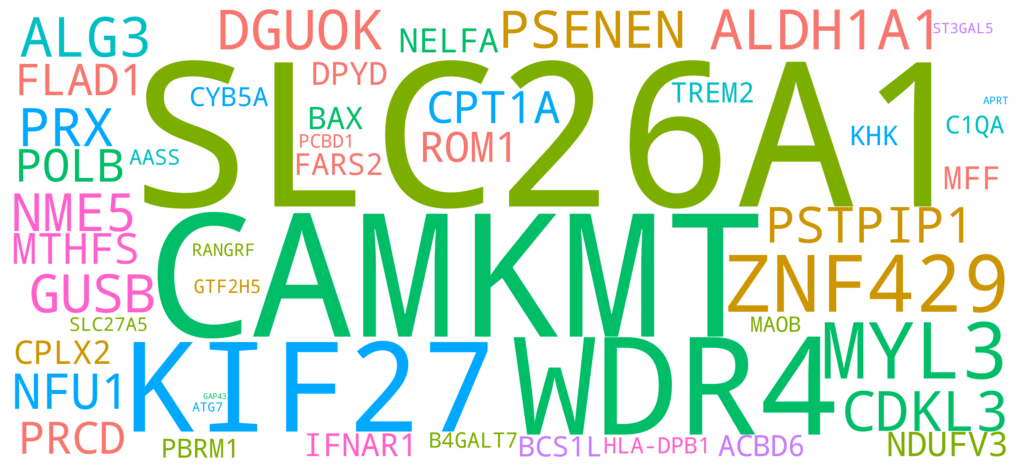

In [44]:
## Save disease relevant genes plot median CPM > 1
plt.imshow(word_cloud_disease_median, interpolation='bilinear', alpha=1)
plt.axis("off")

plt.savefig('../../figures/ASHG_2023/word_cloud_disease_median.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [66]:
novel_relevant_median_words_df

,word_count,gene_name
0,9.0,AASS
1,17.0,ACBD6
2,40.0,ALDH1A1
3,39.0,ALG3
4,2.0,APRT
5,3.0,ATG7
6,9.0,B4GALT7
7,19.0,BAX
8,16.0,BCS1L
9,12.0,C1QA


# Figure 5

In [45]:
## Parse through original GTF 107 Ensembl reference to get transcript biotypes
orig_ref_types = original_ref.loc[original_ref["type"]=="transcript"].copy()
orig_ref_types = parse_df_columns(orig_ref_types, is_ref=True, is_transcript=True)

In [46]:
## Make reference only including protein coding transcripts with a defined CDS
orig_ref_cds = original_ref.loc[original_ref["type"]=="CDS"].copy()
orig_ref_cds = parse_df_columns(orig_ref_cds, is_ref=True, is_transcript=True, is_prot=True)

orig_ref_cds = orig_ref_cds.loc[orig_ref_cds["transcript_biotype"] == "protein_coding"].copy()

In [47]:
## Create unique identifier for protein id
unique_protein_id = pd.DataFrame()
string_orig_ref_cds = orig_ref_cds[['protein_id', 'start', 'end']].copy().astype(str)

unique_protein_id = string_orig_ref_cds.groupby(['protein_id'])[["protein_id", "start", "end"]].transform(lambda x: '-'.join(x))

unique_protein_id["protein_id"] = unique_protein_id["protein_id"].str.split("-", expand=True)[0]
unique_protein_id["unique_identifier"] = "Start coordinates: " + unique_protein_id["start"].copy() + "   End coordinates:" + unique_protein_id["end"].copy()
unique_protein_id = unique_protein_id[["protein_id", "unique_identifier"]].copy()
unique_protein_id.drop_duplicates(inplace=True)
unique_protein_id = unique_protein_id.merge(orig_ref_cds["transcript_id"], left_index=True, right_index=True)

orig_ref_cds = orig_ref_cds.merge(unique_protein_id, on=["protein_id", "transcript_id"], how="inner")
orig_ref_cds["protein_id"] = orig_ref_cds["unique_identifier"].copy()
orig_ref_cds.drop(columns="unique_identifier", inplace=True)

In [48]:
## Only keep protein coding

ref_cds = orig_ref_cds.loc[~orig_ref_cds["protein_id"].isna()].copy()

ref_cds = ref_cds[["transcript_id", "protein_id"]].copy().drop_duplicates()

In [49]:
## Create dataframes for AD and med relevant genes, drop Mitochondria
df_med_relevant = df.merge(disease_relevant_genes, on="gene_id", how="inner")
df_med_relevant = df_med_relevant.loc[df_med_relevant["chr"] != "MT"].copy()

df_brain_relevant = df_med_relevant.merge(brain_disease_gene_ids["gene_id"], on="gene_id", how="inner")

df_ad = df.merge(ad_names, on="gene_id", how="inner")
df_ad = df_ad.loc[df_ad["chr"] != "MT"].copy()

In [50]:
## Only keep protein coding transcripts in expression matrix, adding protein_ids
df_prot_coding_ccds = df.merge(ref_cds[["transcript_id", "protein_id"]],
                                  how="inner", on="transcript_id").drop_duplicates()

In [51]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_genes_all_median = []
list_genes_proteins_median = []
list_genes_med_relevant_median = []
list_genes_med_relevant_proteins_median = []
list_brain_relevant_median = []
list_brain_relevant_proteins_median = []
list_genes_ad_median = []
list_genes_ad_proteins_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    df_gene_multiple_all = df.loc[df["median_CPM"] >= cpm_thresh].copy()
    df_gene_multiple_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] >= cpm_thresh].copy()

    
    df_gene_multiple_prot = df_gene_multiple_prot.loc[~df_gene_multiple_prot.duplicated(subset=["protein_id"], keep=False)].copy()
    df_gene_multiple_prot = df_gene_multiple_prot.loc[df_gene_multiple_prot.duplicated(subset=["gene_id"], keep=False)].copy()

    
    num_genes_multiple_isoforms = df_gene_multiple_all.loc[df_gene_multiple_all.duplicated(subset="gene_id", keep=False)]["gene_id"].nunique()
    num_genes_multiple_prot = df_gene_multiple_prot["gene_id"].nunique()

    list_cpm_thresh.append(cpm_thresh)
    
    list_genes_all_median.append(num_genes_multiple_isoforms)
    list_genes_proteins_median.append(num_genes_multiple_prot)

In [52]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (240*mm, 110*mm)
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 3

In [53]:
## Create CPM 1 Threhold multiple isoform filter
df_multiple_iso = df.loc[df["median_CPM"] > 1].copy()
df_multiple_iso = df_multiple_iso.loc[df_multiple_iso.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_num_isoforms = df_multiple_iso["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_multiple_iso = pd.DataFrame()
df_num_multiple_iso["Number of gene bodies"] = df_num_isoforms.value_counts()
df_num_multiple_iso["Number of transcripts"] = df_num_isoforms.value_counts().index
df_num_multiple_iso["Category"] = "All transcripts"

## Group 7+ transcripts
df_num_isoforms_six = df_num_multiple_iso.loc[df_num_multiple_iso["Number of transcripts"] >= 6].copy()
df_num_isoforms_six = df_num_isoforms_six.groupby("Category").sum()
df_num_isoforms_six["Number of transcripts"] = "6+"
df_num_isoforms_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_multiple_iso = df_num_multiple_iso.loc[df_num_multiple_iso["Number of transcripts"] < 6].copy()
df_num_multiple_iso["Number of transcripts"] = df_num_multiple_iso["Number of transcripts"].astype(str)
df_num_multiple_iso = pd.concat([df_num_multiple_iso, df_num_isoforms_six])

In [54]:
## Create CPM 1 Threhold multiple isoform filter
df_prot_avg_multiple_iso = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] > 1].copy()
df_gene_mutiple_prot = df_prot_avg_multiple_iso.loc[~df_prot_avg_multiple_iso.duplicated(subset=["protein_id"], keep=False)].copy()
df_gene_mutiple_prot = df_gene_mutiple_prot.loc[df_gene_mutiple_prot.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_prot_multiple_isoforms_median = df_gene_mutiple_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_prot_avg = pd.DataFrame()
df_num_isoforms_prot_avg["Number of gene bodies"] = df_numbers_prot_multiple_isoforms_median.value_counts()
df_num_isoforms_prot_avg["Number of transcripts"] = df_numbers_prot_multiple_isoforms_median.value_counts().index
df_num_isoforms_prot_avg["Category"] = "Transcripts with different protein coding sequence"

## Group 7+ transcripts
df_num_isoforms_prot_six = df_num_isoforms_prot_avg.loc[df_num_isoforms_prot_avg["Number of transcripts"] >= 6].copy()
df_num_isoforms_prot_six = df_num_isoforms_prot_six.groupby("Category").sum()
df_num_isoforms_prot_six["Number of transcripts"] = "6+"
df_num_isoforms_prot_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_isoforms_prot_avg = df_num_isoforms_prot_avg.loc[df_num_isoforms_prot_avg["Number of transcripts"] < 6].copy()
df_num_isoforms_prot_avg["Number of transcripts"] = df_num_isoforms_prot_avg["Number of transcripts"].astype(str)
df_num_isoforms_prot_avg = pd.concat([df_num_isoforms_prot_avg, df_num_isoforms_prot_six])

In [55]:
## Concatenate
df_number_isoforms_per_gene = pd.concat([df_num_multiple_iso, df_num_isoforms_prot_avg])

In [56]:
## Create CPM 1 Threhold multiple isoform filter
df_gene_mutiple_med = df_med_relevant.loc[df_med_relevant["median_CPM"] > 1].copy()
df_gene_mutiple_med = df_gene_mutiple_med.loc[df_gene_mutiple_med.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_med_multiple_isoforms_median = df_gene_mutiple_med["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_med_multiple_iso = pd.DataFrame()
df_num_med_multiple_iso["Number of gene bodies"] = df_numbers_med_multiple_isoforms_median.value_counts()
df_num_med_multiple_iso["Number of transcripts"] = df_numbers_med_multiple_isoforms_median.value_counts().index
df_num_med_multiple_iso["Category"] = "All transcripts"

## Group 7+ transcripts
df_num_med_multiple_iso_six = df_num_med_multiple_iso.loc[df_num_med_multiple_iso["Number of transcripts"] >= 6].copy()
df_num_med_multiple_iso_six = df_num_med_multiple_iso_six.groupby("Category").sum()
df_num_med_multiple_iso_six["Number of transcripts"] = "6+"
df_num_med_multiple_iso_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_med_multiple_iso = df_num_med_multiple_iso.loc[df_num_med_multiple_iso["Number of transcripts"] < 6].copy()
df_num_med_multiple_iso["Number of transcripts"] = df_num_med_multiple_iso["Number of transcripts"].astype(str)
df_num_med_multiple_iso = pd.concat([df_num_med_multiple_iso, df_num_med_multiple_iso_six])

In [57]:
## Create CPM 1 Threhold multiple isoform filter
df_prot_avg_multiple_iso = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] > 1].copy()
df_gene_mutiple_med_prot = df_med_relevant.loc[df_med_relevant["median_CPM"] > 1].copy()

df_gene_mutiple_med_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds['transcript_id'].isin(df_gene_mutiple_med_prot["transcript_id"])].copy()                                                   

df_gene_mutiple_med_prot = df_gene_mutiple_med_prot.loc[~df_gene_mutiple_med_prot.duplicated(subset=["protein_id"], keep=False)].copy()
df_gene_mutiple_med_prot = df_gene_mutiple_med_prot.loc[df_gene_mutiple_med_prot.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_med_multiple_isoforms_prot_median = df_gene_mutiple_med_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_prot_med_avg = pd.DataFrame()
df_num_isoforms_prot_med_avg["Number of gene bodies"] = df_numbers_med_multiple_isoforms_prot_median.value_counts()
df_num_isoforms_prot_med_avg["Number of transcripts"] = df_numbers_med_multiple_isoforms_prot_median.value_counts().index
df_num_isoforms_prot_med_avg["Category"] = "Transcripts with different protein coding sequence"

## Group 7+ transcripts
df_num_isoforms_prot_med_six = df_num_isoforms_prot_med_avg.loc[df_num_isoforms_prot_med_avg["Number of transcripts"] >= 6].copy()
df_num_isoforms_prot_med_six = df_num_isoforms_prot_med_six.groupby("Category").sum()
df_num_isoforms_prot_med_six["Number of transcripts"] = "6+"
df_num_isoforms_prot_med_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_isoforms_prot_med_avg = df_num_isoforms_prot_med_avg.loc[df_num_isoforms_prot_med_avg["Number of transcripts"] < 6].copy()
df_num_isoforms_prot_med_avg["Number of transcripts"] = df_num_isoforms_prot_med_avg["Number of transcripts"].astype(str)
df_num_isoforms_prot_med_avg = pd.concat([df_num_isoforms_prot_med_avg, df_num_isoforms_prot_med_six])

In [58]:
## Concatenate
df_number_med_isoforms_per_gene = pd.concat([df_num_med_multiple_iso, df_num_isoforms_prot_med_avg])

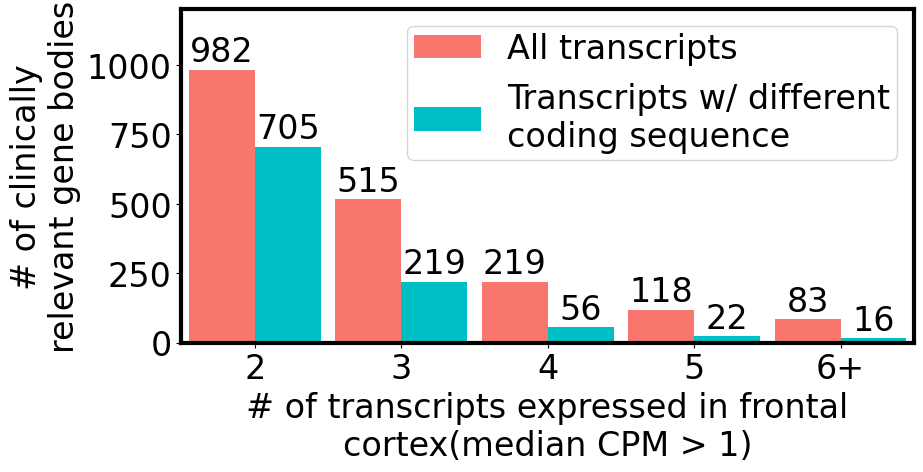

In [59]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_number_med_isoforms_per_gene, y="Number of gene bodies", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[0], ggplot2_colors[4]], saturation=1, dodge=True, width=0.9)


labels = ["All transcripts", "Transcripts w/ different\ncoding sequence"]
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, fontsize=24, borderpad=0.2)
    
ax.set(ylim=(0, 1200), xlim=(-0.5, 4.5))
plt.ylabel("# of clinically\nrelevant gene bodies")
plt.xlabel("# of transcripts expressed in frontal\ncortex(median CPM > 1)")

ax.bar_label(ax.containers[0], fontsize=24, padding=1)
ax.bar_label(ax.containers[1], fontsize=24, padding=1)   


plt.savefig('../../figures/ASHG_2023/number_of_med_relevant_genes_with_multiple_transcripts_cpm_1.pdf', 
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [60]:
## Create CPM 1 Threhold multiple isoform filter
df_gene_brain = df_brain_relevant.loc[df_brain_relevant["median_CPM"] > 1].copy()
df_gene_mutiple_brain = df_gene_brain.loc[df_gene_brain.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_brain_multiple_isoforms_median = df_gene_mutiple_brain["gene_name"].value_counts()


## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_brain_multiple_iso = pd.DataFrame()
df_num_brain_multiple_iso["Number of gene bodies"] = df_numbers_brain_multiple_isoforms_median.value_counts()
df_num_brain_multiple_iso["Number of transcripts"] = df_numbers_brain_multiple_isoforms_median.value_counts().index
df_num_brain_multiple_iso["Category"] = "All transcripts"

## Group 7+ transcripts
df_num_brain_multiple_iso_six = df_num_brain_multiple_iso.loc[df_num_brain_multiple_iso["Number of transcripts"] >= 6].copy()
df_num_brain_multiple_iso_six = df_num_brain_multiple_iso_six.groupby("Category").sum()
df_num_brain_multiple_iso_six["Number of transcripts"] = "6+"
df_num_brain_multiple_iso_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_brain_multiple_iso = df_num_brain_multiple_iso.loc[df_num_brain_multiple_iso["Number of transcripts"] < 6].copy()
df_num_brain_multiple_iso["Number of transcripts"] = df_num_brain_multiple_iso["Number of transcripts"].astype(str)
df_num_brain_multiple_iso = pd.concat([df_num_brain_multiple_iso, df_num_brain_multiple_iso_six])

In [61]:
## Create CPM 1 Threhold multiple isoform filter
df_prot_coding_ccds = df_prot_coding_ccds.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")
df_prot_coding_ccds.drop_duplicates(inplace=True)
df_gene_mutiple_brain_prot = df_brain_relevant.loc[df_brain_relevant["median_CPM"] > 1].copy()


df_gene_mutiple_brain_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds['transcript_id'].isin(df_gene_mutiple_brain_prot["transcript_id"])].copy()                                                   

df_gene_mutiple_brain_prot = df_gene_mutiple_brain_prot.loc[~df_gene_mutiple_brain_prot.duplicated(subset=["protein_id"], keep=False)].copy()
df_gene_mutiple_brain_prot = df_gene_mutiple_brain_prot.loc[df_gene_mutiple_brain_prot.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_brain_multiple_isoforms_prot_median = df_gene_mutiple_brain_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_prot_brain = pd.DataFrame()
df_num_isoforms_prot_brain["Number of gene bodies"] = df_numbers_brain_multiple_isoforms_prot_median.value_counts()
df_num_isoforms_prot_brain["Number of transcripts"] = df_numbers_brain_multiple_isoforms_prot_median.value_counts().index
df_num_isoforms_prot_brain["Category"] = "Transcripts with different protein coding sequence"

## Group 7+ transcripts
df_num_isoforms_prot_brain_six = df_num_isoforms_prot_brain.loc[df_num_isoforms_prot_brain["Number of transcripts"] >= 6].copy()
df_num_isoforms_prot_brain_six = df_num_isoforms_prot_brain_six.groupby("Category").sum()
df_num_isoforms_prot_brain_six["Number of transcripts"] = "6+"
df_num_isoforms_prot_brain_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_isoforms_prot_brain = df_num_isoforms_prot_brain.loc[df_num_isoforms_prot_brain["Number of transcripts"] < 6].copy()
df_num_isoforms_prot_brain["Number of transcripts"] = df_num_isoforms_prot_brain["Number of transcripts"].astype(str)
df_num_isoforms_prot_brain = pd.concat([df_num_isoforms_prot_brain, df_num_isoforms_prot_brain_six])

In [62]:
## Concatenate
df_number_brain_isoforms_per_gene = pd.concat([df_num_brain_multiple_iso, df_num_isoforms_prot_brain])

In [63]:
## Create disease panels
ad_panel = ["BIN1", "TNIP1", "APP", "ADAM17", "EED", "SHARPIN", "PSEN1", "ANK3", "MAPT", "BCKDK"]

pd_als_ftd_late_panel = ["SNCA", "ASXL3", "RIMS1", "GPNMB", "CLCN3", "SOD1", "VCP", "KIF5A", "TARDBP", "ABCC9"]

asd_sud_mdd_schizo = ["ANK2", "ARID1B", "SHANK3", "ADD1", "RHOA", "CTNND1", "MAOA", "PCLO", "CACNA1G", "GRIA3"]